## High Crime Areas show lower Rent Spikes in San Francisco

I decided it would be interesting to explore the relationship between crime levels and rent prices in San Francisco, a city that has seen rent sky-rocket in the last few years.  To do this, I downloaded <a href="https://www.zillow.com/research/data/"> rental price data from Zillow </a> along with <a href="https://www.zillow.com/howto/api/neighborhood-boundaries.htm"> shapefiles </a> that describe neighborhood boundaries.  I used R for the data aggregation and visualization, there was a lot of code that went in to it that I will not explain in depth, but it was a good exercise in working with geospatial data and mapping in R.

My main question was whether or not crime correlated to the speed at which rents are rising in San Francisco.  One might assume intiutively that lower-crime neighborhoods would see larger spikes in rent.  Furthermore, an indicator of rising rent might be declining crime rates.  Unfortunately, the crime data is too sparse to measure a decline in crime (it would be best to measure this year-over-year).  Still, we can explore the relationship between the actual levels of crime and both actual levels and changes in rent prices pretty easily.

In [1]:
library(readr)
library(ggplot2)
library(ggmap)
library(plyr)
library(dplyr)
library(tidyr)
library(rgdal)
library(rgeos)
library(broom)
library(lubridate)


Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: sp
rgdal: version: 1.2-5, (SVN revision 648)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.0.1, released 2015/09/15
 Path to GDAL shared files: C:/Users/JoshOberman/Documents/R/win-library/3.3/rgdal/gdal
 Loaded PROJ.4 runtime: Rel. 4.9.2, 08 September 2015, [PJ_VERSION: 492]
 Path to PROJ.4 shared files: C:/Users/JoshOberman/Documents/R/win-library/3.3/rgdal/proj
 Linking to sp version: 1.2-4 
rgeos version: 0.3-22, (SVN revision 544)
 GEOS runtime version: 3.5.0-CAPI-1.9.0 r4084 
 Linking to sp version: 1.2-4 
 Polygon checking: TRUE 


Attaching package: 'lubridate'

The fo

In [43]:
sf_crime<-read_csv("data/sanfrancisco_incidents_summer_2014.csv")

sf_neighborhoods <- readOGR(dsn="data/ZillowNeighborhoods-CA", 
                              layer="ZillowNeighborhoods-CA")
sf_neighborhoods<-sf_neighborhoods[sf_neighborhoods$CITY=="San Francisco",]
crs<-proj4string(sf_neighborhoods)
sf_neighborhoods<-spTransform(sf_neighborhoods,CRS("+init=epsg:3347"))

begin_end_diff<-function(v){
  (tail(v,1)-head(v,1))/head(v,1)
}

findRegions<-function(lat,long,region_data,initial_crs){
  
  pt<-SpatialPoints(cbind(lat,long),CRS(initial_crs))
  pt<-spTransform(pt, CRS("+init=epsg:3347"))
  match<-over(pt,region_data)
  coords<-coordinates(pt)
  list(neighborhood=as.character(unlist(match$NAME)),id=as.character(unlist(match$id)),
       lat_projected=coords[,1],long_projected=coords[,2])
}

sf_neighborhoods@data$id<-rownames(sf_neighborhoods@data)
sf_neighborhoods <- gBuffer(sf_neighborhoods, byid=TRUE, width=0)
sf.points<-fortify(sf_neighborhoods,region="id")
sf_df<-join(sf.points,sf_neighborhoods@data,by="id")

#get polygon centroids for map labels
centroids<-coordinates(sf_neighborhoods)
centroids<-as.data.frame(centroids)
centroids$id<-rownames(centroids)
colnames(centroids)<-c("long_cent","lat_cent","id")
sf_df<-join(sf_df,centroids,by="id")

#join to property value index dataset
sf_property<-read_csv("data/Neighborhood_Zri_AllHomesPlusMultifamily.csv")
sf_property<-sf_property%>%filter(City=="San Francisco")%>%
  select(-City,-State,-Metro,-CountyName)%>%
  gather(date,index,-RegionID,-RegionName,-SizeRank)
sf_property$date<-paste(sf_property$date,"-01",sep="");sf_property$date<-ymd(sf_property$date)
sf_property_pct_change<-sf_property%>%
  mutate(year=year(date))%>%
  filter(year%in%c(2014,2015)&month(date)%in%c(6,7,8))%>%
  group_by(RegionID,year)%>%
  summarize(mean_idx=mean(index))%>%
  group_by(RegionID)%>%
  summarize(pct_diff_index=begin_end_diff(mean_idx))
sf_property_2014<-sf_property%>%
  filter(year(date)==2014&month(date)%in%c(6,7,8))%>%
  group_by(RegionID)%>%
  summarize(mean_idx_2014=mean(index))

sf_df<-sf_df%>%left_join(sf_property_pct_change,by=c("REGIONID"="RegionID"))%>%left_join(sf_property_2014,by=c("REGIONID"="RegionID"))



#get neighborhood names and id to join from crime dataset
regions<-findRegions(sf_crime$X,sf_crime$Y,sf_neighborhoods,crs)
sf_crime<-cbind(sf_crime,regions)
sf_crime$Date<-mdy(sf_crime$Date)

max_crime_by_neighborhood<-sf_crime%>%
  group_by(id,neighborhood,Category)%>%
  summarize(n_crimes=n())%>%
  group_by(id,neighborhood)%>%
  filter(n_crimes==max(n_crimes))%>%
  select(max_crime_category=Category)


pct_change_crime<-sf_crime%>%
  mutate(month=month(Date,label=T))%>%
  group_by(id,neighborhood,month)%>%
  summarize(n_crimes=n())%>%
  group_by(id,neighborhood)%>%
  summarize(pct_diff=begin_end_diff(n_crimes))%>%
  left_join(centroids,by="id")

crimes_by_neighborhood<-sf_crime%>%
  group_by(id)%>%
  summarize(n_crimes=n())

sf_df<-sf_df%>%left_join(crimes_by_neighborhood,by="id")%>%left_join(max_crime_by_neighborhood,by="id")

Parsed with column specification:
cols(
  IncidntNum = col_integer(),
  Category = col_character(),
  Descript = col_character(),
  DayOfWeek = col_character(),
  Date = col_character(),
  Time = col_time(format = ""),
  PdDistrict = col_character(),
  Resolution = col_character(),
  Address = col_character(),
  X = col_double(),
  Y = col_double(),
  Location = col_character(),
  PdId = col_double()
)


OGR data source with driver: ESRI Shapefile 
Source: "data/ZillowNeighborhoods-CA", layer: "ZillowNeighborhoods-CA"
with 948 features
It has 5 fields


Parsed with column specification:
cols(
  .default = col_integer(),
  RegionName = col_character(),
  City = col_character(),
  State = col_character(),
  Metro = col_character(),
  CountyName = col_character()
)
See spec(...) for full column specifications.
Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
"joining factor and character vector, coercing into character vector"Adding missing grouping variables: `id`, `neighborhood`
Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
"joining character vector and factor, coercing into character vector"Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
"joining factor and character vector, coercing into character vector"Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
"joining factor and character vector, coercing into character vector"

Now we're ready to explore the relationship between the number of crimes commited in summer 2014 and the Zillow Rent Index during that time period.  The color in the map below indicates the ZRI value, some neighborhoods do not have values and are grey.  The size of the bubbles in each neigborhood indicates the number of crimes commited in that neighborhood, and the color of the bubble denotes the crime category that occured the most frequently.

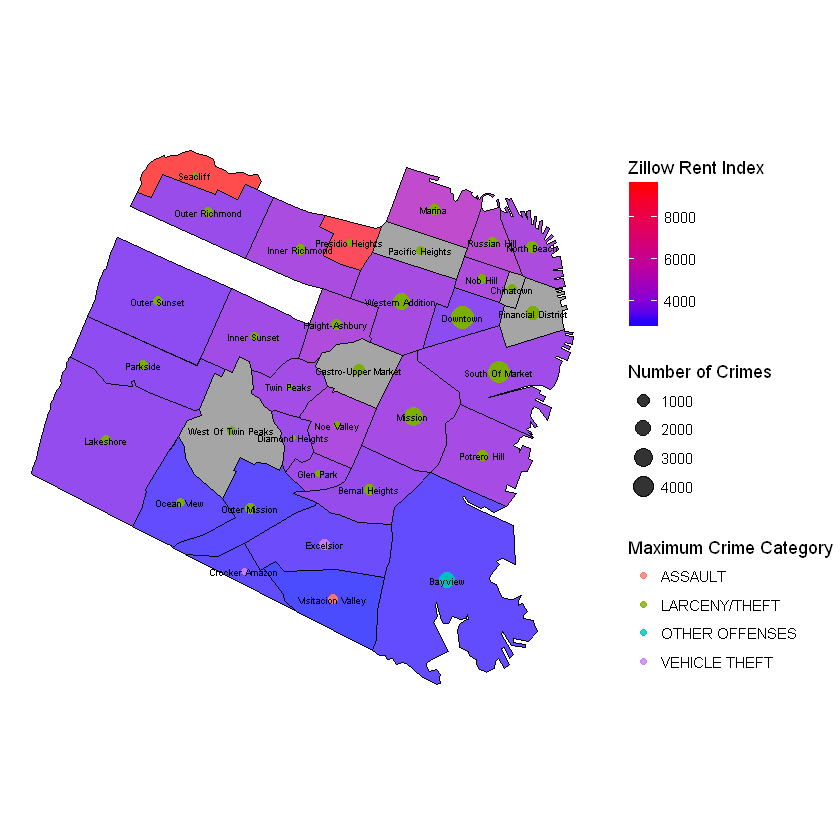

In [44]:
plot_max_crime<-ggplot(sf_df, aes(long,lat,group=id,fill=mean_idx_2014)) + 
      geom_polygon(alpha=0.7) + 
      geom_path(color="black") +
      geom_point(aes(long_cent,lat_cent,size=n_crimes,color=max_crime_category,fill=NULL),alpha=0.8) +
      geom_text(aes(long_cent,lat_cent,group=id,label=NAME),size=2,angle=0,alpha=0.7)+
      coord_equal() + theme_void() + scale_fill_gradient(name="Zillow Rent Index",low="blue",high="red") +
      scale_size_continuous(name="Number of Crimes") +
      scale_color_discrete(name="Maximum Crime Category")
print(plot_max_crime)

This chart shows some correlation between number of crimes and rent, with expensive neighborhoods like Seacliff and Presido Heights exhibiting very low crime counts, and high-crime neighborhoods like Downtown and Mission District exhibiting comparatively lower rent indices.  However, it's clear that location also plays a large role, since the southern part of the city further from downtown is clearly much cheaper than the more centrally located neighborhoods.  Both distance from downtown and proximity to the water likely play a role in neighborhood rent prices.

We can see that there is a relationship between crime and rent prices in summer 2014, but San Francisco is a place of constantly growing rent.  It would therefore be interesting to see whether crime in the summer of 2014 was predictive of * increases * in rent prices from summer 2014 to summer 2015.  To visualize this, I aggregated the mean of the Zillow Rent Index for both of those summers and calculated the percent change from 2014 to 2015.  I constructed a custom arrow geom in ggplot2 that indicates these percent increases

Warning message:
"Removed 92 rows containing missing values (geom_change_arrow)."

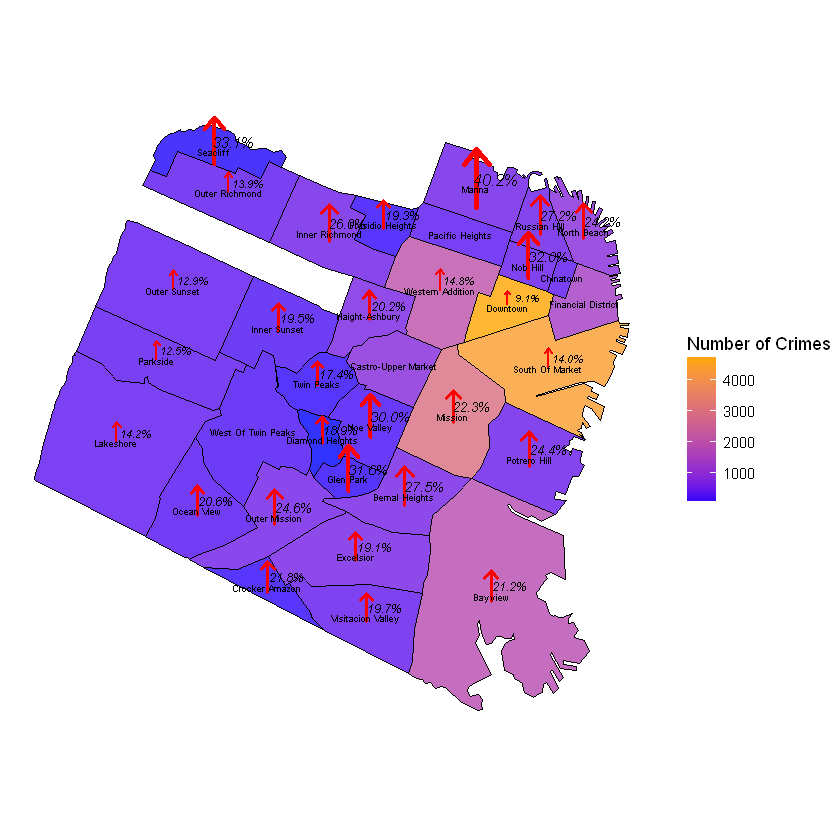

In [45]:
source("geom_change_arrow.R")

p<-ggplot(sf_df, aes(long,lat,group=id,fill=n_crimes)) +
  geom_polygon(alpha=0.8) + 
  geom_path(color="black") +
  geom_change_arrow(aes(long_cent,lat_cent+(lat_cent*0.0003),
                        change=pct_diff_index,group=group)) +
  geom_text(aes(long_cent,lat_cent,group=id,label=NAME),size=2,angle=0)+
  coord_equal() + theme_void() + scale_fill_gradient(name="Number of Crimes",low="blue",high="orange")
print(p)

Here again we see an association between crime levels and percent increases in rent, but with some caveats.  It's very clear that the most high crime areas: Downtown and South of Market, saw some of the lowest increases in rent.  Low crime areas such as Marina, Seacliff, and Glen Park also saw huge spikes in rent.  However, nearby low crime areas such as Presidio Heights and Diamond Heights saw comparatively lower rent increases, while the Mission District, a higher-crime area, saw a comparatively large increase.